In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy

In [85]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

#sns.set_style('white')
plt.style.use('dark_background')

In [86]:
def compute_usage(df):
    onsets = np.where(np.diff(df['syllables']) != 0)[0]
    usage = df.loc[df.index[onsets], 'syllables'].value_counts(normalize=True)
    return usage

In [87]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllables']).mean()
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

In [88]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,name,vmax=1):
    # cohort_dist is matrix of
    seqmatcolor='Purples_r'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,xticklabels=1,yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmax=vmax)
    cmg.fig.set_size_inches(10,10)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels)
    ax.set_yticklabels(age_labels)
    ax.set_title('Syllable Usage based KLD distance',fontsize=20)
    plt.show()

In [89]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_females.parquet')
df = pd.read_parquet(path)

In [90]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [91]:
# calculate usage
fusages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
fusage_mtx = pd.pivot_table(fusages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
fusage_mtx.columns = fusage_mtx.columns.droplevel(0)

#filter most used syllables just females
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [92]:
fdf_all = fusage_mtx.copy()

In [93]:
#get random 16 mice per age
n=16
fdf_all = fdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [94]:
## upload data frame males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_males.parquet')
df = pd.read_parquet(path)

In [95]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [96]:
# calculate usage
musages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
musage_mtx = pd.pivot_table(musages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
musage_mtx.columns = musage_mtx.columns.droplevel(0)

#filter most used syllables just males
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [97]:
mdf_all = musage_mtx.copy()

In [98]:
#get random 16 mice per age
n=16
mdf_all = mdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [99]:
# filter by use of both sexes
combined_df = pd.concat([musages,fusages]).fillna(0)
include_syll = syll_index_above_threshold(combined_df)
mdf = mdf_all[include_syll]
fdf = fdf_all[include_syll]

In [100]:
## kld calculations

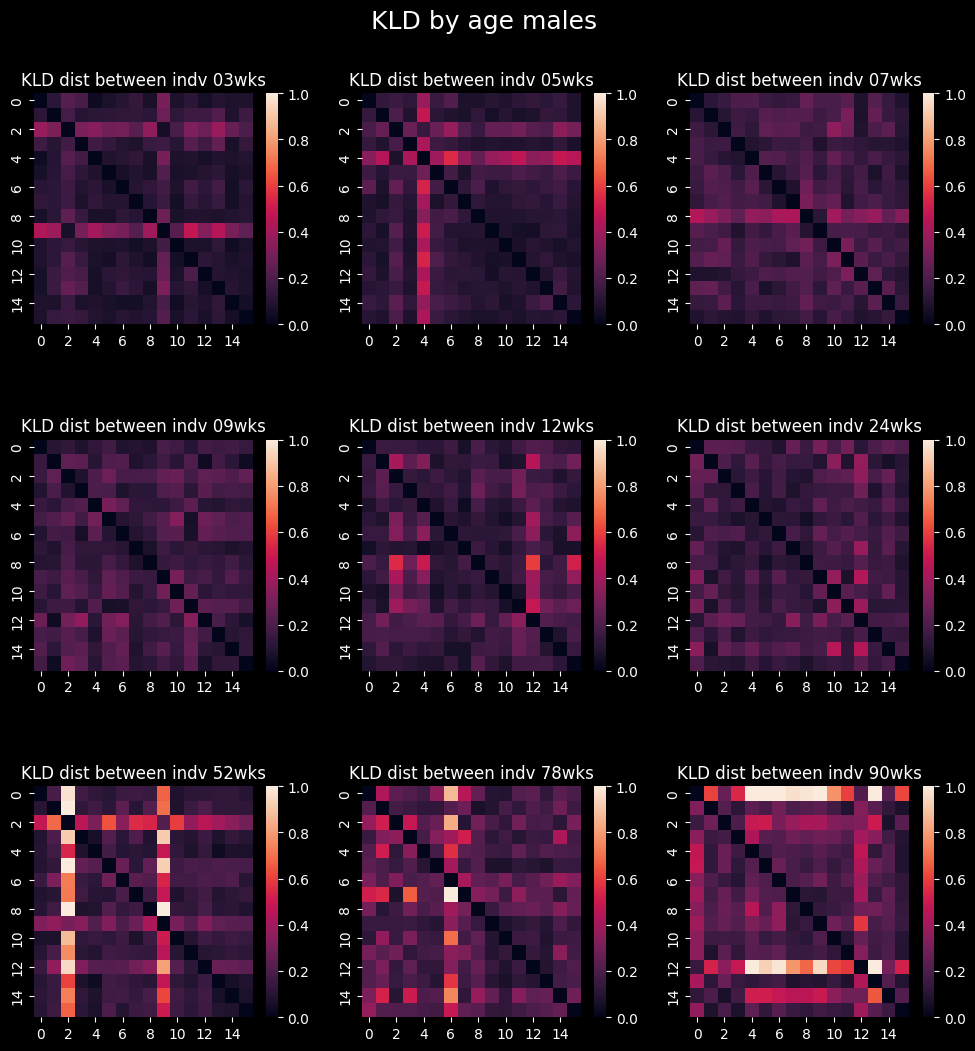

In [101]:
# for males
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("KLD by age males", fontsize=18, y=0.95)

n=0
ages=[]
kld=[]
exp=[]
for age,_df in enumerate(mdf.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(_df[1].index.get_level_values(2).to_numpy())
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    kld.extend(np.mean(kld_temp, axis=1))
    ax = plt.subplot(3, 3, n + 1)
    sns.heatmap(kld_temp,ax=ax, vmax=1.0)
    ax.set_title('KLD dist between indv ' + str(_df[1].index.get_level_values(0).unique().to_numpy()[0]))
    n=n+1
plt.savefig(data_loc +'ontogeny_kld_male_examples.pdf', bbox_inches='tight')

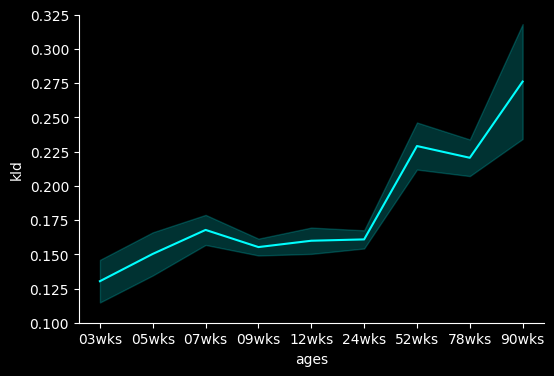

In [102]:
# plot entropy values
df=pd.DataFrame()
df['ages']=ages
df['kld']=kld
df['exp']=exp
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=df, x="ages", y="kld", estimator='mean', errorbar='se', c='cyan')
#ax.set_title('kld males')
sns.despine()
ax.set_ylim(0.10,0.325)
em = df.copy()
plt.savefig(data_loc +'ontogeny_kld_male_line.pdf', bbox_inches='tight')

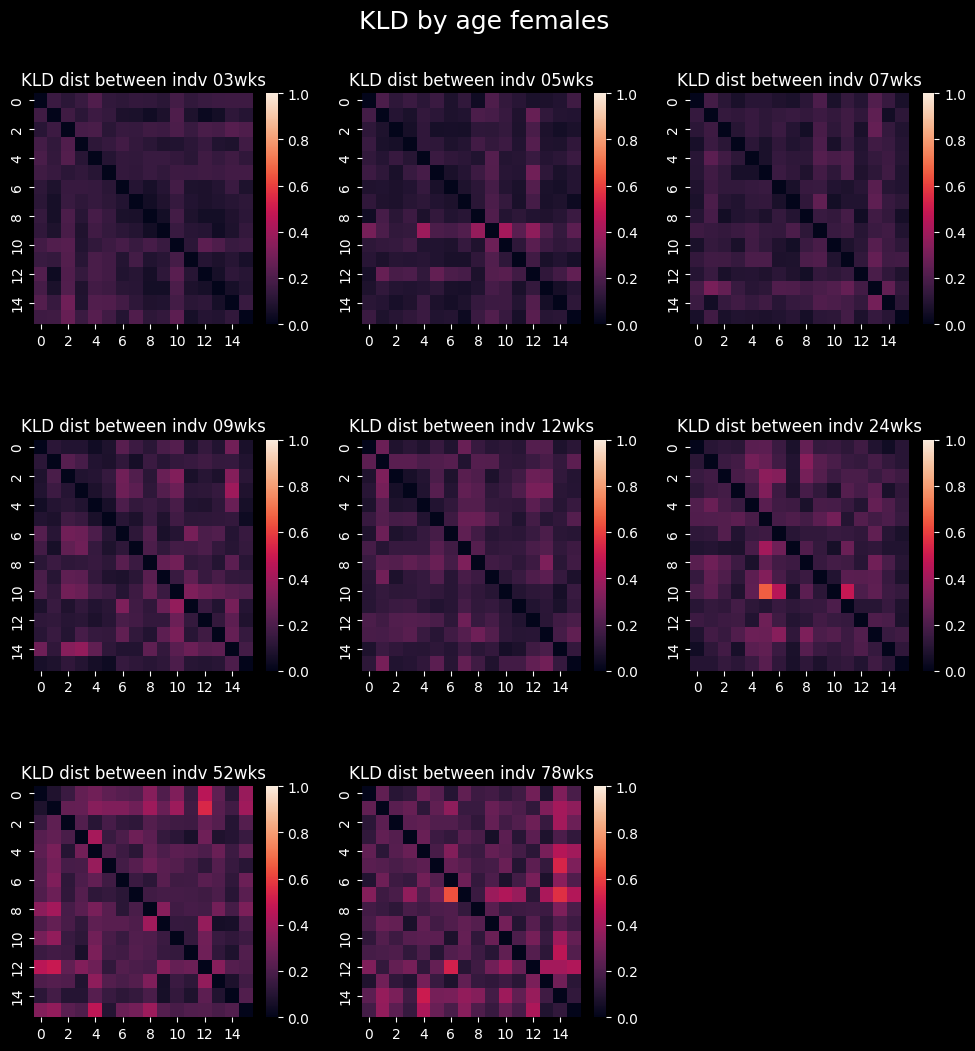

In [108]:
# for females
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("KLD by age females", fontsize=18, y=0.95)

n=0
ages=[]
kld=[]
exp=[]
for age,_df in enumerate(fdf.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(_df[1].index.get_level_values(2).to_numpy())
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    kld.extend(np.mean(kld_temp, axis=1))
    ax = plt.subplot(3, 3, n + 1)
    sns.heatmap(kld_temp,ax=ax, vmax=1.0)
    ax.set_title('KLD dist between indv ' + str(_df[1].index.get_level_values(0).unique().to_numpy()[0]))
    n=n+1
plt.savefig(data_loc +'ontogeny_kld_female_examples.pdf', bbox_inches='tight')

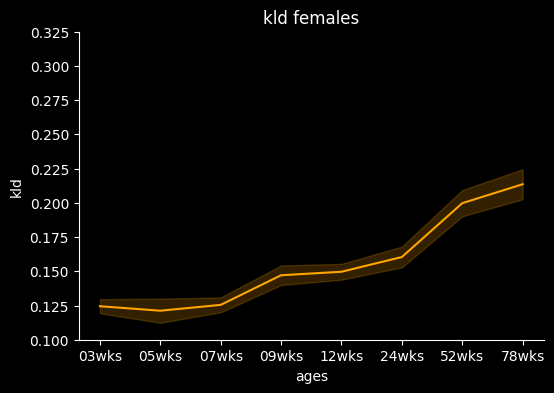

In [104]:
# plot entropy values
df=pd.DataFrame()
df['ages']=ages
df['kld']=kld
df['exp']=exp
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=df, x="ages", y="kld", estimator='mean', errorbar='se',c='orange')
ax.set_title('kld females')
ax.set_ylim(0.10,0.325)
ef = df.copy()
sns.despine()
plt.savefig(data_loc +'ontogeny_kld_female_line.pdf', bbox_inches='tight')

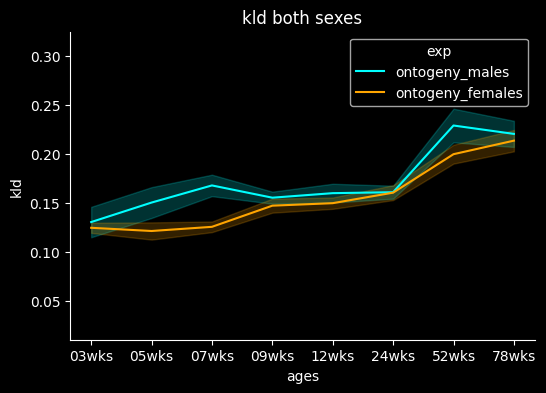

In [105]:
combined=pd.concat([em,ef])
combined=combined[~(combined.ages=='90wks')]
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=combined, x="ages", y="kld", hue='exp', 
             palette = ['cyan','orange'],
             estimator='mean', errorbar='se')
ax.set_title('kld both sexes')
ax.set_ylim(0.01,0.325)
sns.despine()
plt.savefig(data_loc +'ontogeny_kld_mf_line.pdf', bbox_inches='tight')

In [106]:
combined.ages.unique()

array(['03wks', '05wks', '07wks', '09wks', '12wks', '24wks', '52wks',
       '78wks'], dtype=object)

In [107]:
combined

,ages,kld,exp
0,03wks,0.108807,ontogeny_males
1,03wks,0.134946,ontogeny_males
2,03wks,0.262659,ontogeny_males
3,03wks,0.136672,ontogeny_males
4,03wks,0.106955,ontogeny_males
...,...,...,...
123,78wks,0.187760,ontogeny_females
124,78wks,0.273650,ontogeny_females
125,78wks,0.164007,ontogeny_females
126,78wks,0.274367,ontogeny_females
